In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

from jax import lax,ops
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from LeapfrogJAX import LP
from TrainingDataJAX import GenerateTrainingData
from NewtonLAX import NewtonLAX
from ShadowMP import GPMP

# for comparisions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from VariationalMP import VarMPIntegrator
from GPEL_ndim import GPEL

In [3]:
# font size for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Training data generation

In [4]:
# setup problem for generation of training data

# potential and force field
mu = 0.8
V = lambda x: 1/2*(x[0]**2+x[1]**2) + mu*(x[0]**2*x[1]-x[1]**3/3)
f = lambda x: -(x + mu*(jnp.array([2*x[0]*x[1],x[0]**2 - x[1]**2])))
H_ref = lambda x: 1/2*(x[2]**2+x[3]**2) + V(x) # Hamiltonian for reference

# traning data specifications
h=0.1
spacedim=[(-.8, .8), (-.8, .8),(-.8, .8), (-.8, .8)] # range of q1,q2,q1dot,q2dot
dim = int(len(spacedim)/2) # dimension of state space
n_train = 200      # number of generated trajectories 
n_train_length = 4 # length of generated trajectories minus 1
n_h=int(1e3)       # intermediate steps for Leapfrog integration

In [5]:
data,DataPairs,DataTriples=GenerateTrainingData(spacedim,f,n_train,n_train_length,h,n_h)

Text(0, 0.5, '$q_2$')

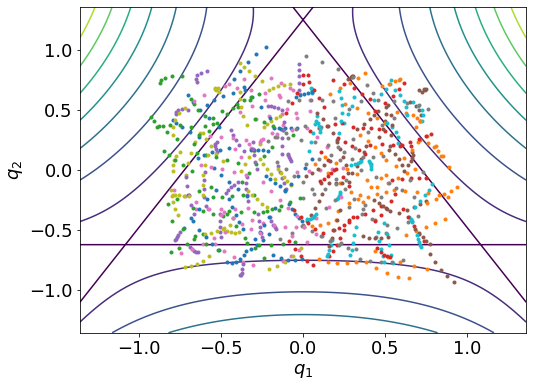

In [6]:
# plot potential and traing data for reference
# (!) the shadow integrator will only see the q-values (!)
n0 = 800
n1 = 800
zoom = 1.7

yy0High,yy1High = jnp.meshgrid(jnp.linspace(spacedim[0][0]*zoom,spacedim[0][1]*zoom,n0),jnp.linspace(spacedim[1][0]*zoom,spacedim[1][1]*zoom,n1)) # reference 
V_ref=V([yy0High,yy1High]) # reference for contour plot

fig, axs = plt.subplots(1, 1,figsize=(8,6))
axs.contour(yy0High,yy1High,V_ref)
axs.contour(yy0High,yy1High,V_ref,levels=[1/(6*mu**2)])

for j in range(0,n_train):
    plt.plot(data[0][j],data[1][j],'.')

axs.set_xlabel('$q_1$')
axs.set_ylabel('$q_2$')

## Set up GP for LSI and train it

In [7]:
# kernel function, rbf

e      = 10.                                           # length scale
c_k      = 1.                                                     # scalar factor for kernel
distsq = lambda x,y: jnp.sum((x-y)**2)
k      = lambda x,y: c_k*jnp.exp(-1/(e**2)*distsq(x,y))

In [8]:
# create instance of LSI integrator
gpmp=GPMP(k,h,DataPairs,DataTriples)

In [9]:
# train LSI integrator
_,_,_=gpmp.train()

start training
calculate non-triviality condition
calculate data consistency equations
solve linear system dimensions: (1202, 800)


In [10]:
# check residue and rank of linear system solved during training 
gpmp.res,gpmp.rank

(DeviceArray([1.99671262e-10], dtype=float64), DeviceArray(114, dtype=int64))

## compute trajectory

In [11]:
# initialise trajectory
q0 = jnp.array([0.675499,0.08])
q0dot = jnp.array([0.,0.])

n = 200000            # number of steps
t = h*jnp.arange(n+1)

In [12]:
# compute trajectory with Lagrangian Shadow Integration

#trj=gpmp.compute_motion(q0,q0dot,n) # uncomment for re-computation

loadedData=pickle.load(open("data/HenonMP_trjHrec_save.p", "rb" )) # load pre-computed data
trj = loadedData[0][:dim]                                     # format data, when pre-computed data is used

In [13]:
# measure how well DEL is solved (1-norm), optional
#gpmp.DELtrj(trj)

Text(0, 0.5, '$q_2$')

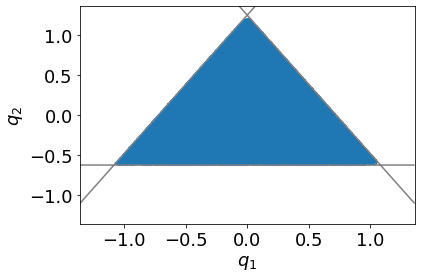

In [14]:
#plot max_index steps of trajectory 
max_index=177400 #177486
plt.plot(trj[0,:max_index],trj[1,:max_index])                           # trajectory
plt.contour(yy0High,yy1High,V_ref,levels=[1/(6*mu**2)],colors=['grey']) # contour for reference
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
#plt.savefig('HenonTrj177400.pdf',bbox_inches='tight')

## Reference trajectory

In [15]:
# reference trajectory
# with Leapfrog and n_h intermediate steps

trj_ref = loadedData[2] # use pre-computed data

# uncomment the following lines for re-computation

#trj_ref=jnp.zeros((2*dim,n+1))
#trj_ref = trj_ref.at[:dim,0].set(q0)
#solp0LP = lambda p0: LP(jnp.hstack([q0,p0]),n_h,h,f)[:dim]-trj[:,1]

#p0 = NewtonLAX(solp0LP,jnp.zeros(dim)) # get the right p to initialise reference (should approximate q0dot up to trunc. error in L)
#trj_ref = trj_ref.at[dim:,0].set(p0)
#trj_ref = lax.fori_loop(0,n,lambda j,trj_ref: trj_ref.at[:,j+1].set(LP(trj_ref[:,j],n_h,h,f) ),trj_ref)

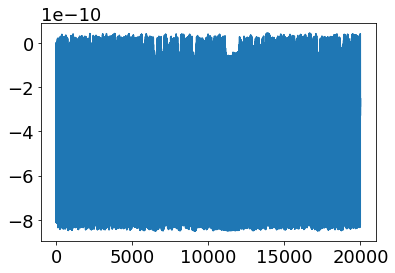

In [16]:
# check energy conservation of reference
plt.plot(t,H_ref(trj_ref)-H_ref(trj_ref[:,0]))

## comparision LSI with reference

Text(0, 0.5, '$q_1$')

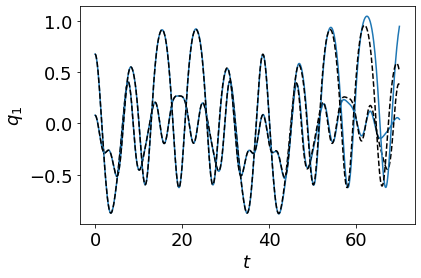

In [17]:
max_index=700
plt.plot(t[:max_index],trj[0,:max_index],'C0-',t[:max_index],trj_ref[0,:max_index],'k--',t[:max_index],trj[1,:max_index],'C0-',t[:max_index],trj_ref[1,:max_index],'k--')
plt.xlabel('$t$')
plt.ylabel('$q_1$')

## compute velocities from the Lagrangian framework

In [18]:
qdotRectrj = loadedData[0][dim:]  # use pre-computed data
#qdotRectrj=gpmp.motionqdot(trj)  # uncomment for re-computation
qqdot_trj = jnp.vstack([trj,qdotRectrj]) # organise data

Text(0, 0.5, '$\\dot{q}_1$')

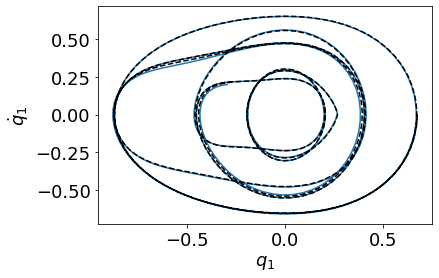

In [19]:
# q_1, q'_1 plot of trajectory
max_index=500 # number of steps
plt.plot(trj[0,:max_index],qdotRectrj[0,:max_index],trj_ref[0,:max_index],trj_ref[2,:max_index],'k--')
plt.xlabel('$q_1$')
plt.ylabel('$\dot{q}_1$')

Text(0, 0.5, '$\\dot{q}_1$')

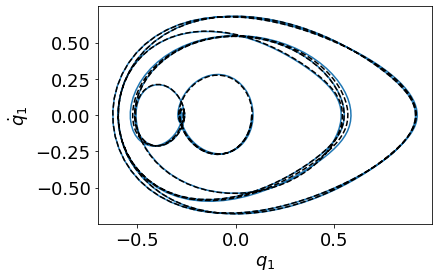

In [20]:
# q_2, q'_2 plot of trajectory
plt.plot(trj[1,:max_index],qdotRectrj[1,:max_index],trj_ref[1,:max_index],trj_ref[3,:max_index],'k--')
plt.xlabel('$q_1$')
plt.ylabel('$\dot{q}_1$')

## Compute Hamiltonian



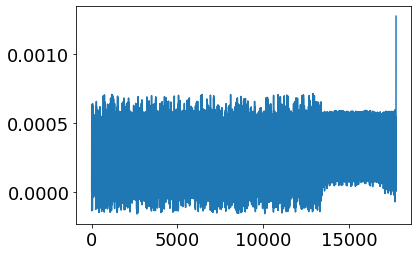

In [21]:
# evaluate exact energy expression along motion

max_index = 177480 # number of steps
Htrj = H_ref(qqdot_trj)
plt.plot(t[:max_index],Htrj[:max_index]-Htrj[0])

In [22]:
# evaluate Hamiltonian identified using the LSI framework along a motion
HRec2 = loadedData[1] # use pre-computed data
#HRec2=gpmp.energy_motion(trj,qdotRectrj) # uncomment for re-computation

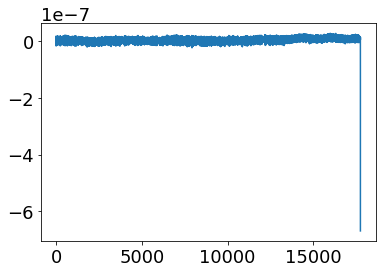

In [23]:
# plot identified energy along motion
t = h*jnp.arange(0,n+1)
plt.plot(t,HRec2-HRec2[0])

In [24]:
# save computed data
#pickle.dump( [qqdot_trj,HRec2,trj_ref], open( "data/HenonMP_trjHrec_save.p", "wb" ) )

## Identification of potential V

In [25]:
# evaluate identified Hamiltonian on mesh in (q_1,q_2,0,0)
nn = (400,400)
spc = ((-1.3, 1.3), (-1., 1.4))
qq1    = jnp.linspace(spc[0][0],spc[0][1],nn[0])
qq2 = jnp.linspace(spc[1][0],spc[1][1],nn[1])
qqq1,qqq2 = jnp.meshgrid(qq1,qq2)

In [26]:
# use pre-computed data
qq1,qq2,VVal = pickle.load(open( "data/HenonMP_V_Contour_scriptComparison.p", "rb" ))

# uncomment the lines below for re-computation
#VVal = jnp.zeros(nn)
#for j1 in tqdm(range(nn[0])):
#    for j2 in range(nn[1]):
#        VVal = VVal.at[j1,j2].set(gpmp.Hamiltonian(jnp.array([qq1[j1],qq2[j2],0.,0.])) )
            

In [27]:
# save computed data
#pickle.dump( [qq1,qq2,VVal], open( "HenonMP_V_Contour_scriptComparison.p", "wb" ) )

JIT compiling Hamiltonian function
JIT compiling BEA formula for Lagrangian L (or a derivative of it)
JIT compiling BEA formula for Lagrangian L (or a derivative of it)


Text(0, 0.5, '$q_2$')

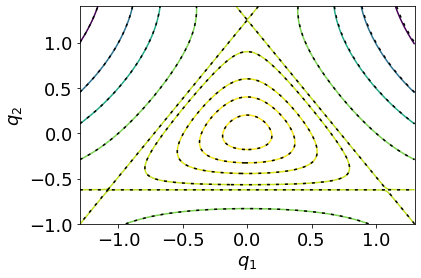

In [28]:
# prepare comparison plot of identified potential and reference potential

V_rec= lambda q: gpmp.Hamiltonian(jnp.hstack([q,jnp.array([0.,0.])])) # short cut to access identified potential

# points through which we compute level sets of the potential
pts_lvs = jnp.array([[0.,0.2],[0.,0.4],[0.,0.6],[0.,0.9],[-1.295976449875111181,-1.],[-1.,0.],[-1.,0.5],[-1.,1.],[-1.3,1.]]) # level 0.000144785

# heights of the level sets
ctlevels = jnp.array([ V_rec(z) for z in pts_lvs ])

# compute reference on fine grid
nn_r = (800,800)
qq1_r    = jnp.linspace(spc[0][0],spc[0][1],nn_r[0])
qq2_r = jnp.linspace(spc[1][0],spc[1][1],nn_r[1])
qqq1_r,qqq2_r = jnp.meshgrid(qq1_r,qq2_r)

V_ref = 1/2*(qqq1_r**2+qqq2_r**2) + 0.8*(qqq1_r**2*qqq2_r-1/3*qqq2_r**3)

lvs_ref = jnp.block([V(pts_lvs[:4].transpose()),jnp.array(1/(6*mu**2)),V(pts_lvs[5:].transpose())]).sort() # heights of reference potnential at the specified points

# plot level sets together
fig = plt.figure()
ax = fig.add_subplot(111)

cs=ax.contour(qqq1,qqq2,-VVal.transpose(),levels=(-ctlevels).sort()) # contour plot identified potential
cs_ref=ax.contour(qqq1_r,qqq2_r,V_ref,levels=lvs_ref,colors=['k'],linestyles=['dashed']) # contour plot reference potential

# set line styles
for c in cs_ref.collections:
    c.set_dashes([(0, (2.0, 4.0))])

ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
#plt.savefig('Henon_Contour.pdf',bbox_inches='tight')

Text(25.200000000000003, 0.5, '$q_2$')

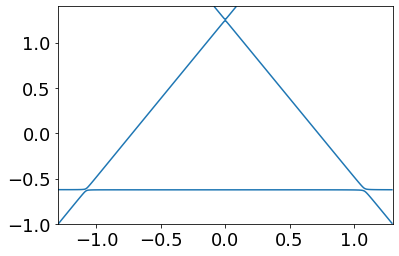

In [29]:
# exclusively plot contour close to separatrix
plt.contour(qqq1,qqq2,VVal.transpose(),colors=['C0'],levels=[0.000144785])
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
#plt.savefig('Henon_Contour_CriticalOnly.pdf',bbox_inches='tight')

## Comparison to GP learning of flow map with velocities approximated by central differences (no variational structure)

In [30]:
# learn flow map directly
# approximate velocities using central finite differences

velocitiesCFD=(data[:dim,:,2:]-data[:dim,:,:-2])/(2*h)
dataCFD=jnp.vstack([data[:dim,:,1:-1],velocitiesCFD])
train_in =dataCFD[:,:,:-1].reshape(2*dim,dataCFD[:,:,:-1].shape[1]*dataCFD[:,:,:-1].shape[2])
train_out=dataCFD[:,:,1:].reshape(2*dim,dataCFD[:,:,1:].shape[1]*dataCFD[:,:,1:].shape[2])

In [31]:
# Fit GP to data with scaled RBF kernel, using ML estimation of the parameters
kernel = C(900., (800., 10000.)) * RBF(13., (10., 200.)) # scaled RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0,random_state=101)
gp.fit(train_in.T,train_out.T)

GaussianProcessRegressor(kernel=30**2 * RBF(length_scale=13), random_state=101)

In [32]:
# predict trajectory using the learned flow map

NSci = len(trj[0]) # number of steps

trjSci = pickle.load(open( "data/HenonMP_GPDirect.p", "rb" ) ) # load pre-computed data

# uncomment for re-computation
#trjSci = jnp.zeros((2*trj.shape[0],NSci)) 
#trjSci = trjSci.at[:,0].set(jnp.hstack([q0,q0dot]))
#for j in tqdm(range(0,trjSci.shape[1]-1)):
#    trjSci = trjSci.at[:,j+1].set(gp.predict(trjSci[:,j].reshape(1,-1))[0])

Text(0, 0.5, '$q_2$')

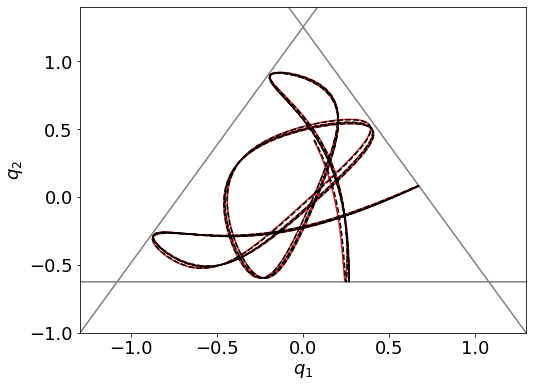

In [33]:
# phase plot and comparision with reference

mm0 = 0 # start
mm = 600 # final step

fig, axs = plt.subplots(1, 1,figsize=(8,6))
axs.contour(qqq1_r,qqq2_r,V_ref,colors=['grey'],levels=[1/(6*mu**2)])
axs.plot(trjSci[0,mm0:mm],trjSci[1,mm0:mm],'C3')
axs.plot(trj_ref[0,mm0:mm],trj_ref[1,mm0:mm],'k--') # reference
axs.set_xlabel('$q_1$')
axs.set_ylabel('$q_2$')

Text(0, 0.5, '$q_2$')

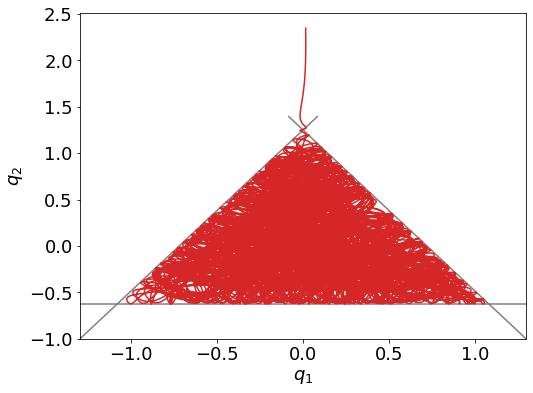

In [34]:
# phase plot long term

mm0 = 0 # start
mm = 14574 #final step

fig, axs = plt.subplots(1, 1,figsize=(8,6))
axs.contour(qqq1_r,qqq2_r,V_ref,colors=['grey'],levels=[1/(6*mu**2)])
axs.plot(trjSci[0,mm0:mm],trjSci[1,mm0:mm],'C3')
axs.set_xlabel('$q_1$')
axs.set_ylabel('$q_2$')
#plt.savefig('HenonTrjSci14574.pdf',bbox_inches='tight')

Text(0, 0.5, '$H$')

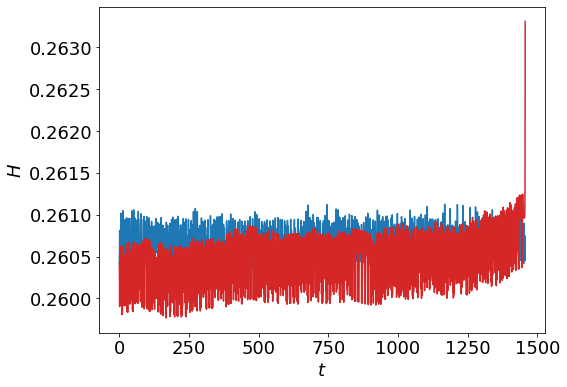

In [35]:
# Compare energy plots of LSI and direct GP
mm1 = 14570 # final step

fig, axs = plt.subplots(1, 1,figsize=(8,6))
axs.plot(    h*jnp.arange(0,len(trj[0,:mm1])),    H_ref(qqdot_trj[:,:mm1]), 'C0')
axs.plot(    h*jnp.arange(0,len(trjSci[0,:mm1])),    H_ref(trjSci[:,:mm1]),'C3')

axs.set_xlabel('$t$')
axs.set_ylabel('$H$')

In [36]:
# save computed data
#pickle.dump( trjSci, open( "HenonMP_GPDirect.p", "wb" ) )

## comparision LGP

In [37]:
# approximate acceleration data using central finite differences
accCFD=(dataCFD[dim:,:,2:]-dataCFD[dim:,:,:-2])/(2*h)
dataCFD2 = jnp.vstack([data[:dim,:,2:-2],velocitiesCFD[:dim,:,1:-1],accCFD])
ELdataCFD = dataCFD2.reshape((6,dataCFD2.shape[1]*dataCFD2.shape[2]))

In [38]:
# create instance of LGP using training data based on central difference approximation
gpel    = GPEL(k,h,ELdataCFD)

In [39]:
# train LGP using training data based on central difference approximation, set scaling of volume of unit hypercube to 100
_= gpel.train(sympl_std_vol=100)

compute data consistency equations and non-triviality conditions
solve linear system dimensions: (402, 200)


In [40]:
# create variational integrator using the midpoint rule for the learned Lagrangian gpel.L
gpelInt=VarMPIntegrator(h,gpel.L)

In [41]:
# compute motion using LGP based on central difference data

# load pre-computed data
trjGPEL,velGPEL,pGPEL = pickle.load(open( "data/HenonMP_GPEL_save.p", "rb" ) )

# len_motion = len(trj[0]) # uncomment for re-computation
#trjGPEL=gpelInt.motion(q0,q0dot,len_motion) #uncomment to re-compute

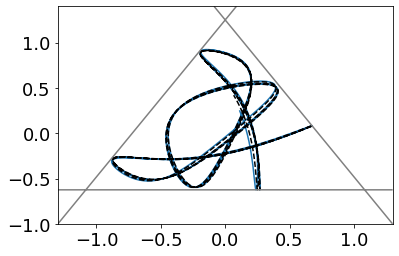

In [42]:
# plot motion
imax=600 # number of steps
plt.plot(trjGPEL[0,:imax],trjGPEL[1,:imax],trj_ref[0,:imax],trj_ref[1,:imax],'k--')
plt.contour(qqq1_r,qqq2_r,V_ref,colors=['grey'],levels=[1/(6*mu**2)])

Text(0, 0.5, '$q_2$')

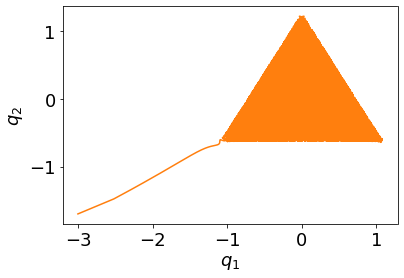

In [43]:
# plot motion
imax=70690 # number of steps
plt.plot(trjGPEL[0,:imax],trjGPEL[1,:imax],'C1')
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
#plt.savefig('HenontrjGPEL70690.pdf',bbox_inches='tight')

In [44]:
# compute velocities and conjugate momenta for motion
#velGPEL,pGPEL = gpelInt.velocities(trjGPEL) # uncomment to re-compute

Text(0, 0.5, '$H_{ref}-H_{ref}(q_0,\\dot{q}_0)$')

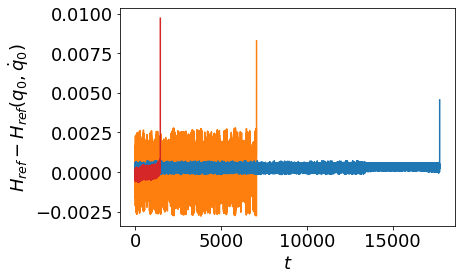

In [45]:
# compare energy behaviour

imax=   70683     # final step for LGP with central difference training
mm1 =   14574     # final step for direct GP with central difference training
imax2 = 177482    # final step for LSI

HGPEL=H_ref(jnp.vstack([trjGPEL,velGPEL])) # data organisation

plt.plot(t[:imax],HGPEL[:imax]-HGPEL[0],'C1')
plt.plot(t[:imax2],Htrj[:imax2]-Htrj[0],'C0')
plt.plot(    h*jnp.arange(0,len(trjSci[0,:mm1])),    H_ref(trjSci[:,:mm1]) - H_ref(trjSci[:,0]) ,'C3')

plt.xlabel('$t$')
plt.ylabel('$H_{ref}-H_{ref}(q_0,\dot{q}_0)$')
#plt.savefig('HenonTrjEnergy.pdf',bbox_inches='tight')

In [46]:
# save computed data
#pickle.dump( [trjGPEL,velGPEL,pGPEL], open( "data/HenonMP_GPEL_save.p", "wb" ) )